# __Projet NLP : Prédiction de note pour des avis de produits Amazon__
## <p style="color:blue;">1- Contexte et description des tâches</p>

Dans le cadre du projet de NLP, nous avons pour objectif de concevoir un système de classification de sentiments appliqué à des avis clients issus d’Amazon. L’objectif principal est de prédire automatiquement la note qu’un utilisateur a attribuée à un produit en se basant uniquement sur le titre et le contenu textuel de l’avis qu’il a rédigé.

<p style="color:red;">A CONTINUER</p>


In [ ]:
!pip install nltk pandas numpy matplotlib scikit-learn spacy tqdm seaborn
!python -m spacy download en_core_web_sm

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.5 MB 11.7 MB/s eta 0:00:01
   ---------------- ----------------------- 4.7/11.5 MB 11.9 MB/s eta 0:00:01
   ------------------------ --------------- 7.1/11.5 MB 11.8 MB/s eta 0:00:01
   -------------------------------- ------- 9.4/11.5 MB 12.0 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 11.6 MB/s eta 0:00:00
   ------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import spacy
nlp = spacy.load("en_core_web_sm")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier



## <p style="color:blue;">2- Le dataset</p> 
Le dataset utilisé dans ce projet est un CSV qui contient des avis d’utilisateurs Amazon portant sur divers produits. Chaque ligne du fichier est structurée en trois colonnes :

- `label` : la note attribuée par l’utilisateur au produit (de 1 à 5 étoiles),

- `title` : le titre de l’avis,

- `review` : le contenu textuel de l’avis.


In [2]:
train_df = pd.read_csv("../amazon_review_full_csv/train.csv", header=None, names=["label","title","review"], 
                       on_bad_lines='skip',  # pour ignorer les lignes corrompues
                       encoding="utf-8")

In [3]:
#test affichage
train_df.head(5)


,label,title,review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [4]:
# Distrib des labels (pour l'instant de 1 à 5)
train_df['label'].value_counts()


label
3    600000
5    600000
4    600000
1    600000
2    600000
Name: count, dtype: int64

### <p style="color:#d300ff;">- Objectif de classification</p>
Afin de simplifier la tâche de classification, on a regroupé les notes (qui allaient de 1 à 5) comme suit dans une quatrième colonne `label_3` :

- __négatif__ : notes de 1 ou 2 regroupés en 1,

- __neutre__ : note de 3 regroupés en 2,

- __positif__ : notes de 4 ou 5 regroupés en 3.

Cette transformation permet de formuler une tâche de classification en trois classes correspondant à des niveaux de sentiment.

In [5]:
# Préparation des données
#On va regrouper les labels 1,2 ; 3 ; 4,5 en 3 classes : négatif, neutre, positif
def map_label(x):
    if x in [1,2]:
        return 1  # negatif
    elif x == 3:
        return 2  # neutre
    else:
        return 3  # positif

train_df['label_3'] = train_df['label'].apply(map_label)

train_df['label_3'].value_counts()


label_3
3    1200000
1    1200000
2     600000
Name: count, dtype: int64

Et enfin, pour éviter les erreurs liées aux titres/review vides, on a fusionné les 2 colonnes dans une cinquième nommée `full_review`.

Au final, on ne gardera que `label_3` et `full_review` car les autres nous seront inutiles.

In [6]:
print("Valeurs nulles par colonne:")
print(train_df.isna().sum())

Valeurs nulles par colonne:
label        0
title      188
review       0
label_3      0
dtype: int64


In [7]:
# Fusion des colonnes title et review
train_df['title'] = train_df['title'].fillna('') # Remplacer les valeurs nulles par une chaîne vide
train_df['full_review'] = train_df['title'] + ' ' + train_df['review'] 
train_df.head()

,label,title,review,label_3,full_review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...,2,more like funchuck Gave this to my dad for a g...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...,3,Inspiring I hope a lot of people hear this cd....
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,3,The best soundtrack ever to anything. I'm read...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...,3,Chrono Cross OST The music of Yasunori Misuda ...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...,3,Too good to be true Probably the greatest soun...


In [8]:
# Suppression des colonnes inutiles
train_df = train_df[['label_3', 'full_review']]
train_df.head()

,label_3,full_review
0,2,more like funchuck Gave this to my dad for a g...
1,3,Inspiring I hope a lot of people hear this cd....
2,3,The best soundtrack ever to anything. I'm read...
3,3,Chrono Cross OST The music of Yasunori Misuda ...
4,3,Too good to be true Probably the greatest soun...


In [9]:
df_negatif  = train_df[train_df['label_3'] == 1].sample(n=100000, random_state=42)
df_neutre = train_df[train_df['label_3'] == 2].sample(n=100000, random_state=42)
df_positif = train_df[train_df['label_3'] == 3].sample(n=100000, random_state=42)

df_reduit = pd.concat([df_negatif, df_neutre, df_positif], ignore_index=True)
df_reduit = df_reduit.sample(frac=1, random_state=42).reset_index(drop=True)

df_reduit['label_3'].value_counts()

label_3
1    100000
2    100000
3    100000
Name: count, dtype: int64

### <p style="color:#d300ff;">- Répartition des données</p>
Pour réaliser le travail on dispose de deux fichiers :

- `train.csv` : le jeu de données d'entraînement qui contient 3 millions d'avis utilisateurs dont 1.2 million négatifs, 1.2 million positifs et 600 000 neutres, 
- `test.csv` : le jeu de données de test qui contient 650 000 d'avis utilisateurs

Pour réduire les temps de calcul, nous avons réduit le nombre d'itération par classe à 300000 ce qui sera largement suffissant pour l'entrainement.

## <p style="color:blue;">3- Nettoyage des données</p> 

normalisation (mettre en minuscule les caractères) : basic_clean

Tokenisation (séparation du string en mots)

lemmatisation (réduction du mot à sa forme canonique)

In [10]:
def basic_clean(text):
    # Retirer les balises HTML
    text = re.sub(r'<.*?>', ' ', text)

    # Remplacer tout caractère qui n'est ni lettre ni ponctuation basique par un espace
    text = re.sub(r'[^a-zA-Z!?.,\'\s]', ' ', text)

    # Mise en minuscule
    text = text.lower()

    # Remplacer les espaces multiples par un seul espace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df_reduit['clean_review'] = df_reduit['full_review'].apply(basic_clean)
df_reduit.head()

,label_3,full_review,clean_review
0,1,Not 8 cups Kettle description says it holds 8 ...,not cups kettle description says it holds cups...
1,1,Tries TOO hard to be serious This was a fair m...,tries too hard to be serious this was a fair m...
2,2,blind tiger There are scenes missing from this...,blind tiger there are scenes missing from this...
3,3,CANNIBALIZED IT'S WELL SPENT MONEY. I'M GETTIN...,cannibalized it's well spent money. i'm gettin...
4,2,FURminator- A Lot of Fluff This is just an ave...,furminator a lot of fluff this is just an aver...


In [ ]:
from tqdm import tqdm
tqdm.pandas()

def spacy_batch_lemmatize(texts):
    lemmatized = []
    for doc in tqdm(nlp.pipe(texts, batch_size=1000, n_process=-1), total=len(texts)):
        lemmatized.append([token.lemma_ for token in doc if not token.is_space])
    return lemmatized

#df_reduit['lemmatized_tokens'] = spacy_batch_lemmatize(df_reduit['clean_review'].tolist())

100%|██████████| 300000/300000 [11:07<00:00, 449.36it/s] 


In [ ]:
#df_reduit.to_csv("df_reduit_lemmatise_100k.csv", index=False)
df_reduit = pd.read_csv("df_reduit_lemmatise_100k.csv", encoding="utf-8")
df_reduit.head()


,label_3,full_review,clean_review,lemmatized_tokens
0,1,Not 8 cups Kettle description says it holds 8 ...,not cups kettle description says it holds cups...,"['not', 'cup', 'kettle', 'description', 'say',..."
1,1,Tries TOO hard to be serious This was a fair m...,tries too hard to be serious this was a fair m...,"['try', 'too', 'hard', 'to', 'be', 'serious', ..."
2,2,blind tiger There are scenes missing from this...,blind tiger there are scenes missing from this...,"['blind', 'tiger', 'there', 'be', 'scene', 'mi..."
3,3,CANNIBALIZED IT'S WELL SPENT MONEY. I'M GETTIN...,cannibalized it's well spent money. i'm gettin...,"['cannibalize', 'it', 'be', 'well', 'spend', '..."
4,2,FURminator- A Lot of Fluff This is just an ave...,furminator a lot of fluff this is just an aver...,"['furminator', 'a', 'lot', 'of', 'fluff', 'thi..."


## <p style="color:blue;">4- Traitement des données</p> 
### <p style="color:#d300ff;">- Séparation</p>
3 jeux de données : 
train_data, val_data, test_data (stratify garde la meme portion de label_3 dans chaque jeu de données)
- eviter l'overfitting

### <p style="color:#d300ff;">- TF-IDF Vectorisation</p>


Afin de transformer les avis utilisateurs (sous forme de texte) en données exploitables par les modèles de machine learning, nous avons utilisé la méthode TF-IDF vue en cours.

Cette technique permet de pondérer chaque mot en fonction de son importance dans un document, tout en tenant compte de sa fréquence dans l’ensemble du corpus. Cela permet de réduire l’impact des mots trop courants (ex. "the", "product") tout en mettant en valeur ceux qui sont plus informatifs pour différencier les classes (positif, neutre, négatif).

Ce traitement nous permet d'obtenir une représentation vectorielle normalisée des textes, prête à être exploitée par des modèles de classification supervisée.

In [14]:
# Rejoindre les tokens lemmatisés en une seule chaîne de caractères
df_reduit['text_final'] = df_reduit['lemmatized_tokens'].apply(lambda x: ' '.join(eval(x)))
df_reduit.head()


,label_3,full_review,clean_review,lemmatized_tokens,text_final
0,1,Not 8 cups Kettle description says it holds 8 ...,not cups kettle description says it holds cups...,"['not', 'cup', 'kettle', 'description', 'say',...",not cup kettle description say it hold cup . w...
1,1,Tries TOO hard to be serious This was a fair m...,tries too hard to be serious this was a fair m...,"['try', 'too', 'hard', 'to', 'be', 'serious', ...",try too hard to be serious this be a fair movi...
2,2,blind tiger There are scenes missing from this...,blind tiger there are scenes missing from this...,"['blind', 'tiger', 'there', 'be', 'scene', 'mi...",blind tiger there be scene miss from this vide...
3,3,CANNIBALIZED IT'S WELL SPENT MONEY. I'M GETTIN...,cannibalized it's well spent money. i'm gettin...,"['cannibalize', 'it', 'be', 'well', 'spend', '...",cannibalize it be well spend money . I be get ...
4,2,FURminator- A Lot of Fluff This is just an ave...,furminator a lot of fluff this is just an aver...,"['furminator', 'a', 'lot', 'of', 'fluff', 'thi...",furminator a lot of fluff this be just an aver...


In [15]:
# 1) Séparation train/test+val
train_df, temp_df  = train_test_split(df_reduit, test_size=0.3, stratify=df_reduit['label_3'], random_state=42)

# 2) Séparation test et val (depuis les 30% restants)
val_df, test_df = train_test_split(temp_df , test_size=0.5, stratify=temp_df ['label_3'], random_state=42)


In [16]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                        max_df=0.95, min_df=5, sublinear_tf=True # on ignore les mots trop fréquents ou trop rares
                        )

# Apprentissage sur le train
X_train_tfidf = tfidf.fit_transform(train_df['text_final'])

# Application sur val et test
X_val_tfidf = tfidf.transform(val_df['text_final'])
X_test_tfidf = tfidf.transform(test_df['text_final'])

# Cibles
y_train = train_df['label_3']
y_val   = val_df['label_3']
y_test  = test_df['label_3']

In [17]:
print("X_train :", X_train_tfidf.shape)
print("X_val   :", X_val_tfidf.shape)
print("X_test  :", X_test_tfidf.shape)

X_train : (210000, 10000)
X_val   : (45000, 10000)
X_test  : (45000, 10000)


### <p style="color:#d300ff;">- Entraînement des modèles</p>


>Linear SVC 

Le SVM classique (avec noyau) etant trop lent pour des données de grande dimension comme TF-IDF on va utiliser LinearSVC qui est optimisé pour le type de données qu'on possède (texte vectorisé).

In [18]:
svm_model = LinearSVC() 

# Entraînement
svm_model.fit(X_train_tfidf, y_train)

LinearSVC()

In [19]:
# Prédictions
y_val_pred = svm_model.predict(X_val_tfidf)

# Évaluation
print("Classification Report :\n")
print(classification_report(y_val, y_val_pred, digits=3))

Classification Report :

              precision    recall  f1-score   support

           1      0.725     0.747     0.736     15000
           2      0.618     0.564     0.590     15000
           3      0.752     0.795     0.773     15000

    accuracy                          0.702     45000
   macro avg      0.698     0.702     0.699     45000
weighted avg      0.698     0.702     0.699     45000



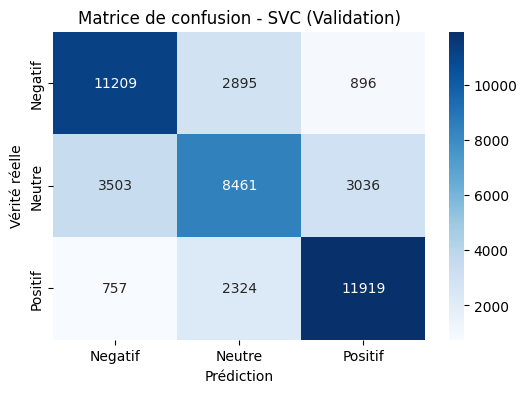

In [20]:
# On établit une matrice de confusion 
conf_matrix = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Neutre', 'Positif'],
            yticklabels=['Negatif', 'Neutre', 'Positif'])
plt.xlabel("Prédiction")
plt.ylabel("Vérité réelle")
plt.title("Matrice de confusion - SVC (Validation)")
plt.show()


#### Analyse des résultats
Après entraînement du modèle LinearSVC, le modèle atteint une accuracy globale de 71,6 % sur le jeu de validation ce qui est un résultat satisfaisant.
La classe neutre est la plus difficile à prédire (60% contre 75% pour négatif et 78% pour positif)

La matrice de confusion montre que :

- Les avis positifs sont bien classés, mais certains sont pris pour des neutres.

- Les avis neutres sont plus souvent mal classés, répartis entre négatif et positif.

- Les avis négatifs sont bien identifiés, avec quelques confusions vers neutre.

Cela confirme que la frontière entre négatif et positif est bien apprise mais que les avis neutres sont moins bien définis, ce qui vient surement du fait qu’ils partagent des mots avec les deux autres classes.

On va maintenant tenter d'améliorer les résultats en testant avec un modèle non-linéaire : réseau de neurones MLP

<br><br>

> MLP

Contrairement à LinearSVP qui cherche une frontière linéaire, un MLP peut apprendre des relations non linéaires entre les mots et les sentiments.

Il combine les mots entre eux, ce qui est utile quand le sens vient de la structure ("not bad" ≠ "bad").

In [21]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64), # deux couches cachées avec 128 et 64 neurones respectivement
    activation='relu',          # fonction d’activation non-linéaire ReLU
    solver='adam',              # algorithme d’optimisation efficace
    max_iter=50,                # nombre d’itérations limité pour tester rapidement
    random_state=42
)

mlp_model.fit(X_train_tfidf, y_train)


c:\Users\Matis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=50, random_state=42)

In [22]:
# Evaluation
y_val_pred_mlp = mlp_model.predict(X_val_tfidf)

print("Classification Report (MLP):")
print(classification_report(y_val, y_val_pred_mlp, digits=3))


Classification Report (MLP):
              precision    recall  f1-score   support

           1      0.677     0.701     0.688     15000
           2      0.542     0.524     0.533     15000
           3      0.724     0.722     0.723     15000

    accuracy                          0.649     45000
   macro avg      0.647     0.649     0.648     45000
weighted avg      0.647     0.649     0.648     45000



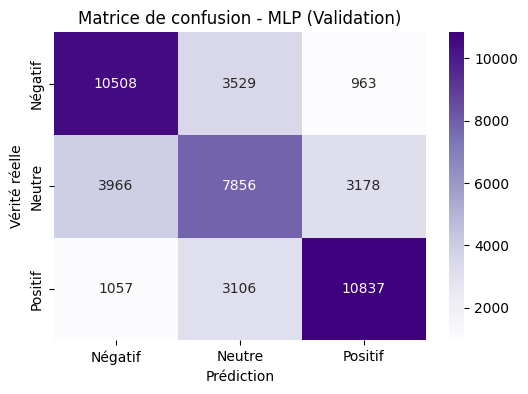

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matrice de confusion
conf_matrix = confusion_matrix(y_val, y_val_pred_mlp)

# Affichage
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Négatif', 'Neutre', 'Positif'],
            yticklabels=['Négatif', 'Neutre', 'Positif'])
plt.xlabel("Prédiction")
plt.ylabel("Vérité réelle")
plt.title("Matrice de confusion - MLP (Validation)")
plt.show()


#### Analyse des résultats
Nous avons testé un modèle MLP (réseau de neurones multi-couches) avec une architecture simple :

- 1 couche cachée de 100 neurones

- 20 itérations (epochs)

Sur le jeu de validation, le MLP atteint une accuracy globale de 65.9 %, ce qui est légèrement inférieur au modèle SVM (71.6 %).

Détail par classe :
- Classe 1 (négatif) : le modèle obtient un f1-score de 0.693, avec un bon équilibre précision/rappel.

- Classe 2 (neutre) : reste la classe la plus difficile à prédire, avec un f1-score de 0.551, souvent confondue avec les autres classes.

- Classe 3 (positif) : le modèle atteint un f1-score de 0.733, montrant une bonne capacité à détecter les avis positifs.

#### Conclusion

Le MLP réussit à capturer des patterns intéressants, mais reste moins performant que le SVM dans notre cas.

On pourrait tenter d'améliorer les résultats en engmentant le nombre d'itérations à 50 (max_iter=50), ou encore d'ajouter une couche cachée de neurones, mais cela augmenterai également beaucoup le temps d'exécution.

In [59]:
y_test_pred = svm_model.predict(X_test_tfidf)

print("Résultats finaux sur le jeu de test :")
print(classification_report(y_test, y_test_pred, digits=3))


Résultats finaux sur le jeu de test :
              precision    recall  f1-score   support

           1      0.736     0.764     0.750     45000
           2      0.640     0.573     0.605     45000
           3      0.756     0.807     0.781     45000

    accuracy                          0.715    135000
   macro avg      0.711     0.715     0.712    135000
weighted avg      0.711     0.715     0.712    135000

